In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from _plotly_future_ import v4_subplots
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import pickle 
from random import gauss


In [1]:
def calculate_delta(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    return  np.exp(-d*Tau) *norm.cdf(Z)

def calculate_gamma(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    return np.exp(-d*Tau) * norm.pdf(Z)/(S*sig*np.sqrt(Tau))

def calculate_charm(S,K,r,d,Tau,sig):
    Z = (np.log(S/K) + (r-d+sig**2/2) * Tau) / (sig*np.sqrt(Tau))
    d2 = Z - sig*np.sqrt(Tau)
    A = d*np.exp(-d*Tau) * norm.cdf(Z)
    B = np.exp(-d*Tau) * norm.pdf(Z)* ((2*(r-d)*Tau) - d2*sig*np.sqrt(Tau))/(S*Tau*sig*np.sqrt(Tau))
    return A-B

In [42]:
# Monte Carlo Simulation of Stock Price
def generate_asset_price(S0, sig, r, dt):
    return S0 * np.exp((r - 0.5 * sig**2) * dt + sig * np.sqrt(dt) * gauss(0,1.0))



In [43]:
# Start from S0 = 100
path=[100]

# Parameters
sig = 0.85
r   = 0.1 
T   = 1
N_datapoints = 365
dt = T/N_datapoints

for i in range(T*N_datapoints):
    path.append(generate_asset_price(path[-1], sig, r, dt))
    
plt.plot(path)

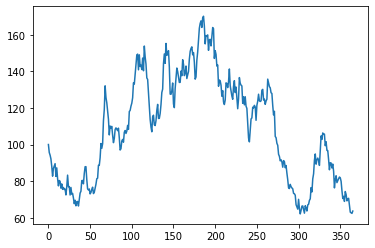